## Masking by depth

In [10]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

In [2]:
bath_data = xr.open_dataset('~/Research/data/ocean.static.CM2p6.nc')['ht']
bath_data

<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 ...
    geolat_t  (yt_ocean, xt_ocean) float32 ...
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

In [3]:
bath_pandas = bath_data.to_pandas()

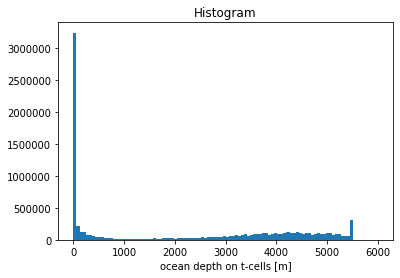

In [4]:
xr.plot.hist(bath_data, bins=100, range = [0, 6000], figsize=(6,4));

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


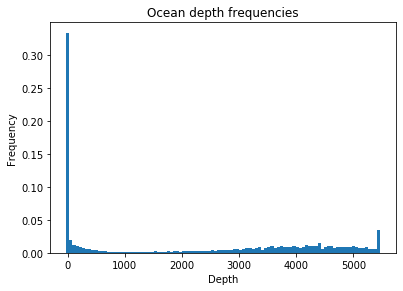

In [5]:
# Create histograms by frequency
max_depth = 5500
nbins = 100
hist_array, bins = np.histogram(bath_data.values, bins=nbins, range = [0,5500])
grid_dims = np.shape(bath_data.values)
total_grid_count = grid_dims[0]*grid_dims[1]

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.bar(bins[:-1], hist_array/total_grid_count, width=max_depth/nbins)
ax.set_title('Ocean depth frequencies')
ax.set_xlabel('Depth')
ax.set_ylabel('Frequency')
plt.show()

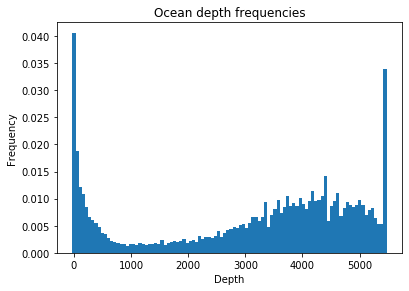

In [6]:
# Create histograms but ignore landmasses, where ocean height = 0
max_depth = 5500
nbins = 100
hist_array, bins = np.histogram(bath_data.values, bins=nbins, range = [1,5500])
grid_dims = np.shape(bath_data.data)
total_grid_count = grid_dims[0]*grid_dims[1]

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.bar(bins[:-1], hist_array/total_grid_count, width=max_depth/nbins)
ax.set_title('Ocean depth frequencies')
ax.set_xlabel('Depth')
ax.set_ylabel('Frequency')
plt.show()

In [7]:
# Total number (and percentage) of grid points at depths greater than 1500m (estimated by bins)
# Nope this is wrong
first_bin = np.where(bins>1500)[0][0]
pct_ocn_over_1500 = np.sum(hist_array[first_bin:-1])/np.sum(hist_array)
pct = 0.71* (1-pct_ocn_over_1500)
pct

0.20794236034396368

We get the following percentages of data kept for the following depths:
* 1000m depths: 19.1%
* 1500m depths: 20.7%
* 2000m depths: 22.8%
There are some systematic errors

In [8]:
# More accurate (but slower) computation: no binning.
bath_data = xr.open_dataset('~/Research/data/ocean.static.CM2p6.nc')['ht']
bath_data = bath_data.where(bath_data > 0, np.nan).where(bath_data < 1500, np.nan)
count = 0
for i in range(2700):
    for j in range(3600):
        if not np.isnan(bath_data.data[i,j]):
            count += 1
print(count/ (2700*3600))

0.14932150205761316


Results:
* 1000m: 13.4%
* 1500m: 14.9%
* 2000m: 16.7%

## Masking land coordinates

**Introduction to the "where" function**

~~We can mask all land points using something like Cartopy, (see for example [here](https://gist.github.com/Jsvcycling/d883e2335495b7e454740c16e07da233) ) or we can just mask based on points currently characterized as NaNs or 0).~~

Actually, it looks like xarray has a couple of native `where` functions for masking data. Here's the syntax for one such function:

`DataArray.where(self, cond, other=<NA>, drop: bool = False)`

* `cond (DataArray or Dataset with boolean dtype)` – Locations at which to preserve this object’s values.

* `other (scalar, DataArray or Dataset, optional)` – Value to use for locations in this object where cond is False. By default, these locations filled with NA.

* `drop (boolean, optional)` – If True, coordinate labels that only correspond to False values of the condition are dropped from the result. Mutually exclusive with other.

[Source](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html)

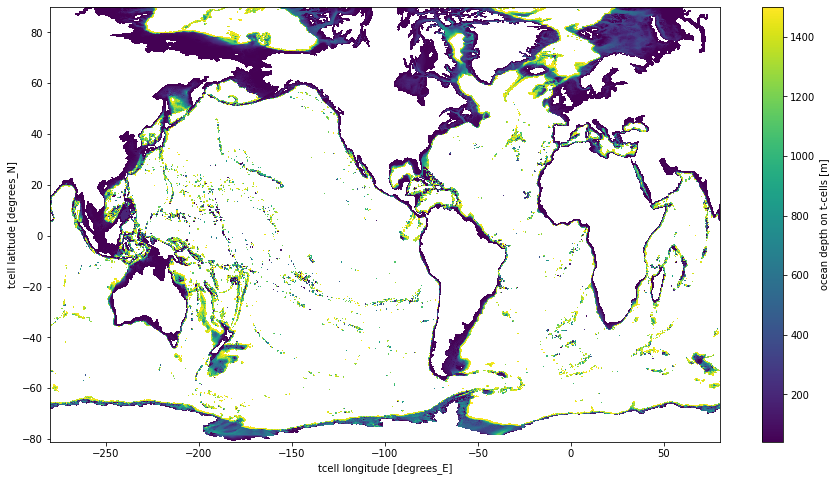

In [9]:
bath_data = bath_data.where(bath_data > 0, np.nan)
bath_data.plot(figsize=(15,8))
plt.show()

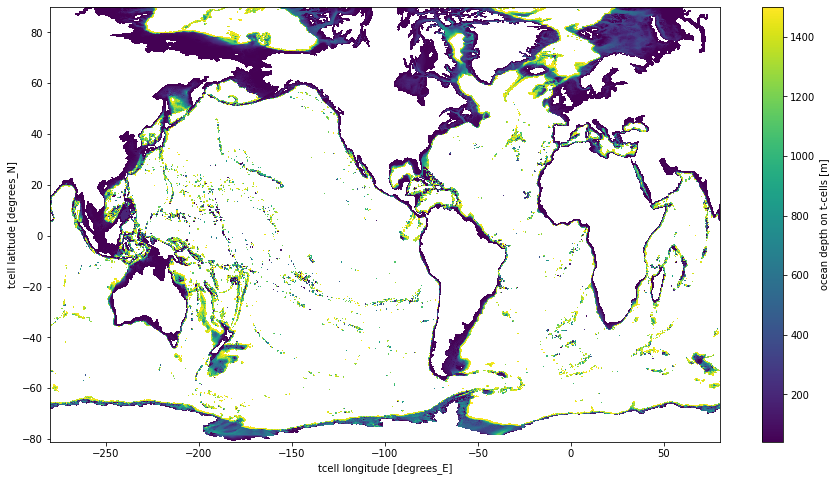

In [9]:
# Mask depths greater than 1500m as well
bath_data = bath_data.where(bath_data > 0, np.nan)
bath_data = bath_data.where(bath_data < 2000, np.nan)
bath_data.plot(figsize=(15,8))
#plt.savefig('/Users/Andrew/Desktop/mask-2000m')

## Making a function which returns a 1D list of all coastal coordinates:
Here, we iterate over the filtered bathymetry, where the only data that is kept is in the range (0,1500).

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

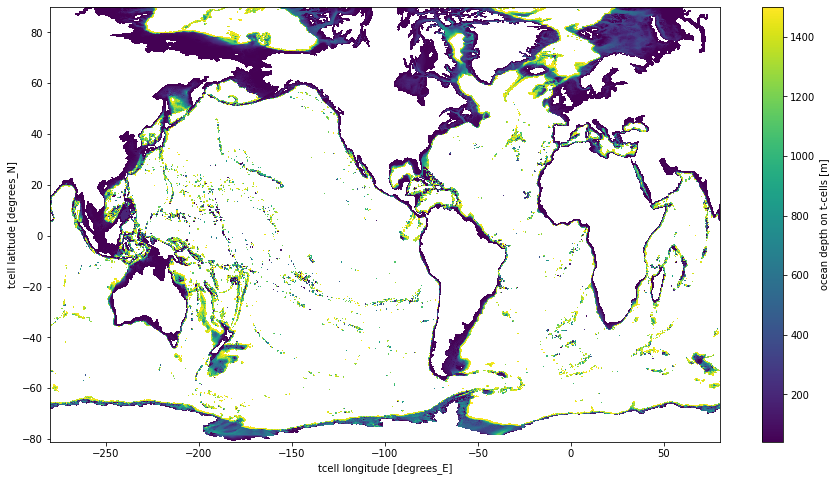

In [4]:
bath_data = xr.open_dataset('~/Research/data/ocean.static.CM2p6.nc')['ht']
bath_data = bath_data.where(bath_data > 0, np.nan).where(bath_data < 1500, np.nan)
bath_data.plot(figsize=(15,8))
bath_data.data

In [11]:
%%time
# Determine total number of cells to iterate over
count = 0
for x_idx in range(3600):
    for y_idx in range(2700):
        if not np.isnan(bath_data.data[y_idx,x_idx]):
            count += 1

KeyboardInterrupt: 

In [3]:
%%time
# Usually takes around 2 mins
count = 1451405 # from previous cell
lats = np.zeros(count)
longs = np.zeros(count)
k = 0
for x_idx in range(3600):
    for y_idx in range(2700):
        if not np.isnan(bath_data.data[y_idx,x_idx]):
            lats[k] = bath_data.coords['yt_ocean'].data[y_idx]
            longs[k] = bath_data.coords['xt_ocean'].data[x_idx]
            k += 1

IndexError: index 1451405 is out of bounds for axis 0 with size 1451405

In [15]:
#Sanity check
print(lats[-1]) # Shouldn't be zero
print(longs[-1])
print(lats) # should be coordinate range
print(len(lats), len(longs)) # Should be both 1451405
for i in range(10):
    print(bath_data.sel(yt_ocean=lats[10*i], xt_ocean=longs[10*i]).values) # Should print values in range (0,1500)

0.0
0.0
[-67.97219247 -67.92995311 -67.88771376 ...   0.           0.
   0.        ]
1451405 1451405
40.4674
627.1061
768.4934
610.97516
346.82846
1463.3157
40.4674
40.4674
641.41187
643.51


In [16]:
# Save lats and longs in a pandas dataframe
df = pd.DataFrame({'lat': lats,
                  'long': longs})

In [ ]:
df

Quick computations: 1,451,405 spacepoints x 5844 timepoints = 8.4 e9 floats. Still a lot of data  

Let's try this with a much smaller array: just include coastal points where ocean is shallower than 100m:

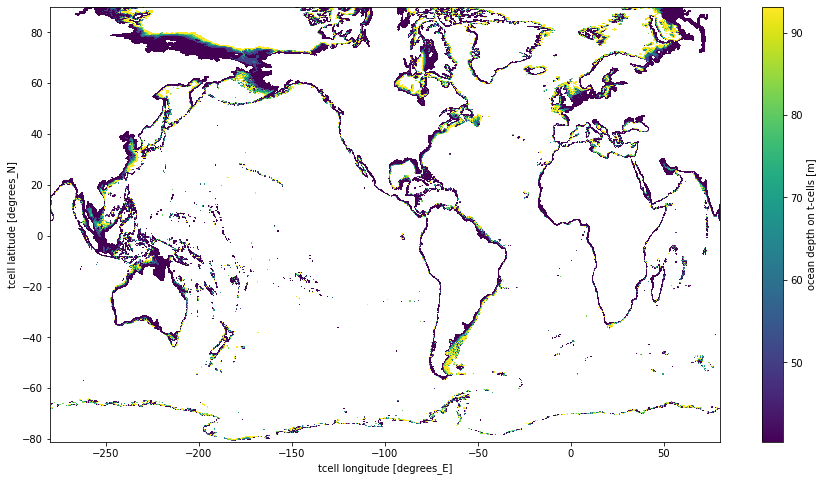

In [3]:
bath_data = xr.open_dataset('~/Research/data/ocean.static.CM2p6.nc')['ht']
bath_data = bath_data.where(bath_data > 0, np.nan).where(bath_data < 100, np.nan)
bath_data.plot(figsize=(15,8))
# plt.savefig('/Users/Andrew/Desktop/mask-100m')

In [6]:
count = 0
for i in range(3600):
    for j in range(2700):
        if not np.isnan(bath_data.data[j,i]):
            count += 1

#count 5.5% of total, so final dataset would be 14 GB, I think
lats = np.zeros(count)
longs = np.zeros(count)

k = 0
# i is x index (longitudinal), j is y index (latitudinal)
for i in range(3600):
    for j in range(2700):
        if not np.isnan(bath_data.data[j,i]):
            lats[k] = bath_data.coords['yt_ocean'].data[j]
            longs[k] = bath_data.coords['xt_ocean'].data[i]
            k += 1

In [20]:
df = pd.DataFrame({'lat': lats,
                   'long': longs})

In [21]:
df

,lat,long
0,-67.972192,-279.95
1,-67.929953,-279.95
2,6.038792,-279.95
3,6.138228,-279.95
4,9.900367,-279.95
...,...,...
538693,11.766417,79.95
538694,11.864298,79.95
538695,11.962145,79.95
538696,12.059955,79.95


In [22]:
df.to_hdf('~/Research/data/coord_table.h5', key='df', mode='w')

In [7]:
ds = xr.Dataset({'lat':lats, 'long':longs})

In [8]:
ds.to_netcdf('~/Research/data/shelf_coords.nc')

In [9]:
ds = xr.open_dataset('~/Research/data/shelf_coords.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 538698, long: 538698)
Coordinates:
  * lat      (lat) float64 -67.97 -67.93 6.039 6.138 ... 11.86 11.96 12.06 12.16
  * long     (long) float64 -279.9 -279.9 -279.9 -279.9 ... 79.95 79.95 79.95
Data variables:
    *empty*

I'm finding that it will probably be more convenient to save the lat/long *indices* instead of the coordinate values, so we'll do a similar thing to above here.

In [7]:
count = 0
for i in range(3600):
    for j in range(2700):
        if not np.isnan(bath_data.data[j,i]):
            count += 1

#count 5.5% of total, so final dataset would be 14 GB, I think
y_idxs = np.zeros(count)
x_idxs = np.zeros(count)

k = 0
# i is x index (longitudinal), j is y index (latitudinal)
for i in range(3600):
    for j in range(2700):
        if not np.isnan(bath_data.data[j,i]):
            y_idxs[k] = j
            x_idxs[k] = i
            k += 1
x_idxs

array([   0.,    0.,    0., ..., 3599., 3599., 3599.])

In [8]:
x_idxs

array([   0.,    0.,    0., ..., 3599., 3599., 3599.])

In [12]:
np.save('x_idx_shelf', x_idxs)
np.save('y_idx_shelf', y_idxs)

In [11]:
df

,ys,xs
0,311.0,0.0
1,312.0,0.0
2,1305.0,0.0
3,1306.0,0.0
4,1344.0,0.0
...,...,...
538693,1363.0,3599.0
538694,1364.0,3599.0
538695,1365.0,3599.0
538696,1366.0,3599.0
